# Control Architecture

<img src="Drone2.png" width="300" height="300">

The cascading control architecture will be developed for the 2D drone. As you can remember the drone consists of two propellers located at a distance $l$ from the center of mass. It can generate a thrust by them to overcome the earth gravity and can rotate along the center of mass by creating thrust difference between these two propellers, allowing it to move laterally. In this exercise, we will use the highly simplified model of the drone in order to concentrate our efforts on the controller architecture and not on the drone itself.

Similarly the state can be described by next vector: $X = [z , y, \phi, \dot{z}, \dot{y},\dot{\phi}]$. Thus we will truck drones position in 2 dimension and its rotation along the $x$ axis.

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import math
from math import sin, cos
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
import random

pylab.rcParams['figure.figsize'] = 10, 10

### Linearized drone.
As you remember the equations of motion for a 2D drone have the next form for a given $\phi$ angle:
$$
\begin{align}
\ddot{z} &= g - \frac{k_f}{m}(\omega_1^2+\omega_2^2) \cos(\phi) \\
\ddot{y} &= \frac{k_f}{m}(\omega_1^2+\omega_2^2) \sin(\phi)\\
\ddot{\phi} &= \frac{l k_f}{I}(\omega_1^2 - \omega_2^2) 
\end{align}
$$

For a small rolling angle $\phi \ll 1$, $\sin{\phi} = \phi$ and $\cos{\phi} =1 $. Additionally we will simplify the drone dynamics and will replace the total force  and torque by $u_1$ and $u_2$ inputs from the controller. 

$$
\begin{align}
F &= k_f(\omega_1^2 + \omega_2^2) = u_1 \\
\tau &= k_f(\omega_1^2 - \omega_2^2) = u_2
\end{align}
$$
The given modification keep the drone dynamics intact while helping us to avoid all the complex calculations that we had to perform to control it using the older model. The price that we have to pay for this simplification is that now we need to transfer drone parameters like mass and moment of inertia to the control object in order to get the correct control values. 

Thus the simplified linear drone model will have the next equations of motion:
$$
\begin{align}
\ddot{z} &= g - \frac{u_1}{m} \\
\ddot{y} &= g\phi \\
\ddot{\phi} &= \frac{u_2}{I_{xx}}
\end{align}
$$

The `LinearDroneInTwoD` object will have the similar properties and function as the one that we covered in the last lesson. The `advance_state` function will take controls parameters $u_1$ and $u_2$ with $dt$ time and will return the new drone's state vector. 

In [2]:
class LinearDroneInTwoD:
    
    def __init__(self,
                 I_x = 0.1, # moment of inertia around the x-axis
                 m = 0.2,   # mass of the vehicle 
                ):
        
        self.I_x = I_x
        self.m = m
        
        self.u1 = 0.0
        self.u2 = 0.0
        self.g = 9.81
        
        self.X = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
    
    @property
    def y_dot_dot(self):
        phi = self.X[2]
        return self.g * phi
    
    @property
    def z_dot_dot(self):
        return self.g - self.u1/self.m
    
    @property
    def phi_dot_dot(self):
        return self.u2 / self.I_x
   
    def advance_state(self, u1, u2,  dt):
        self.u1 = u1
        self.u2 = u2
        
        X_dot = np.array([self.X[3], 
                        self.X[4],
                        self.X[5], 
                        self.z_dot_dot,
                        self.y_dot_dot, 
                        self.phi_dot_dot])

        # Change in state will be 
        self.X = self.X + X_dot * dt
        return self.X 

### Controller
In this section, we will create the controller object described in class. The schematic description of the cascading controller looks like next:
<img src="CascadingController2.png" width="800" >

The controller architecture uses three PD controllers to control the drone. One PD controller is used to generate the thrust and control the altitude while two PD controllers are used to control the lateral motion. The first one receives the desired lateral position information containing $y$ , $\dot{y}$ and $\ddot{y}$ based on which is outputs the commanded $\phi$ roll angle. The second PD controller is used to sets a torque value to achieve the desired angle. In most cases, the inner controller responsible for roll angle operates at the higher frequency than the ones that are used to control the position. 

In [3]:
class LinearCascadingController:
    
    def __init__(self,
                 m,
                 I_x,
                 z_k_p=1.0,   
                 z_k_d=1.0,   
                 y_k_p=1.0,
                 y_k_d=1.0,
                 phi_k_p=1.0,
                 phi_k_d=1.0):
        
        self.z_k_p = z_k_p
        self.z_k_d = z_k_d   
        self.y_k_p = y_k_p
        self.y_k_d = y_k_d
        self.phi_k_p = phi_k_p
        self.phi_k_d = phi_k_d
        
        self.g = 9.81
        self.I_x = I_x
        self.m = m

The altitude PD controller will take input parameters of $(z_{target},z_{actual},\dot{z}_{target}, \dot{z}_{actual}, \ddot{z}_{target})$ and outputs the $u_1$ instead of $\bar{u}_1$. The reson behind transfering the mass and the moment of inertia of the drone to controller is to convert the $\bar{u}_1$ into $u_1$. As a reminder $\bar{u_1} = g - \frac{u_1}{m}$.

In [4]:
%%add_to LinearCascadingController

def altitude_controller(self, 
                z_target, 
                z_actual, 
                z_dot_target, 
                z_dot_actual,
                z_dot_dot_target
                ):
    
    z_err = z_target - z_actual
    z_err_dot = z_dot_target - z_dot_actual

    p_term = self.z_k_p * z_err
    d_term = self.z_k_d * z_err_dot

    u_1_bar = p_term + d_term + z_dot_dot_target
    
    u_1 = self.m* (self.g - u_1_bar)
    
    return u_1

The latteral motion is executed by rolling the drone along the $x$ axis with small angle which will creat the force along the desired motion dirction. The controller takes input parameters of $(y_{target},y_{actual},\dot{y}_{target}, \dot{y}_{actual}, \ddot{y}_{target})$ and outputs the $\phi_{commanded}$

In [5]:
%%add_to LinearCascadingController

def lateral_controller(self, 
                        y_target, 
                        y_actual, 
                        y_dot_target, 
                        y_dot_actual,
                        y_dot_dot):
    
    y_err = y_target - y_actual
    y_err_dot = y_dot_target - y_dot_actual

    p_term = self.y_k_p * y_err
    d_term = self.y_k_d * y_err_dot

    phi_commanded = (p_term + d_term + y_dot_dot) / self.g
    
    return phi_commanded 


Attitude controller uses the same PD controller which will take input from the lateral direction controller $\phi_{commanded}$ and will output the torque value. Keep in mind that we are using PD controller and giving $\phi_{commanded}$ and $\dot{\phi}_{commanded} = 0 $.

In [6]:
%%add_to LinearCascadingController

def attitude_controller(self, 
                        phi_target, 
                        phi_actual, 
                        phi_dot_target, 
                        phi_dot_actual):
    
    phi_err = phi_target - phi_actual
    phi_err_dot = phi_dot_target - phi_dot_actual

    p_term = self.phi_k_p * phi_err
    d_term = self.phi_k_d * phi_err_dot

    u_2 = (p_term + d_term ) * self.I_x
    
    return u_2

Before using the controller developed above, we need to create the flight path. Which we have chosen to be figure 8 executed for 200 seconds with position update rate of 10 Hz $(dt=0.1)$. The executed path is described as:
$$
\begin{align}
z & = a_z \sin{\omega_z t} \\
y & = a_y \cos{\omega_y t}
\end{align}
$$

where $\omega_y = \omega_z / 2$. 

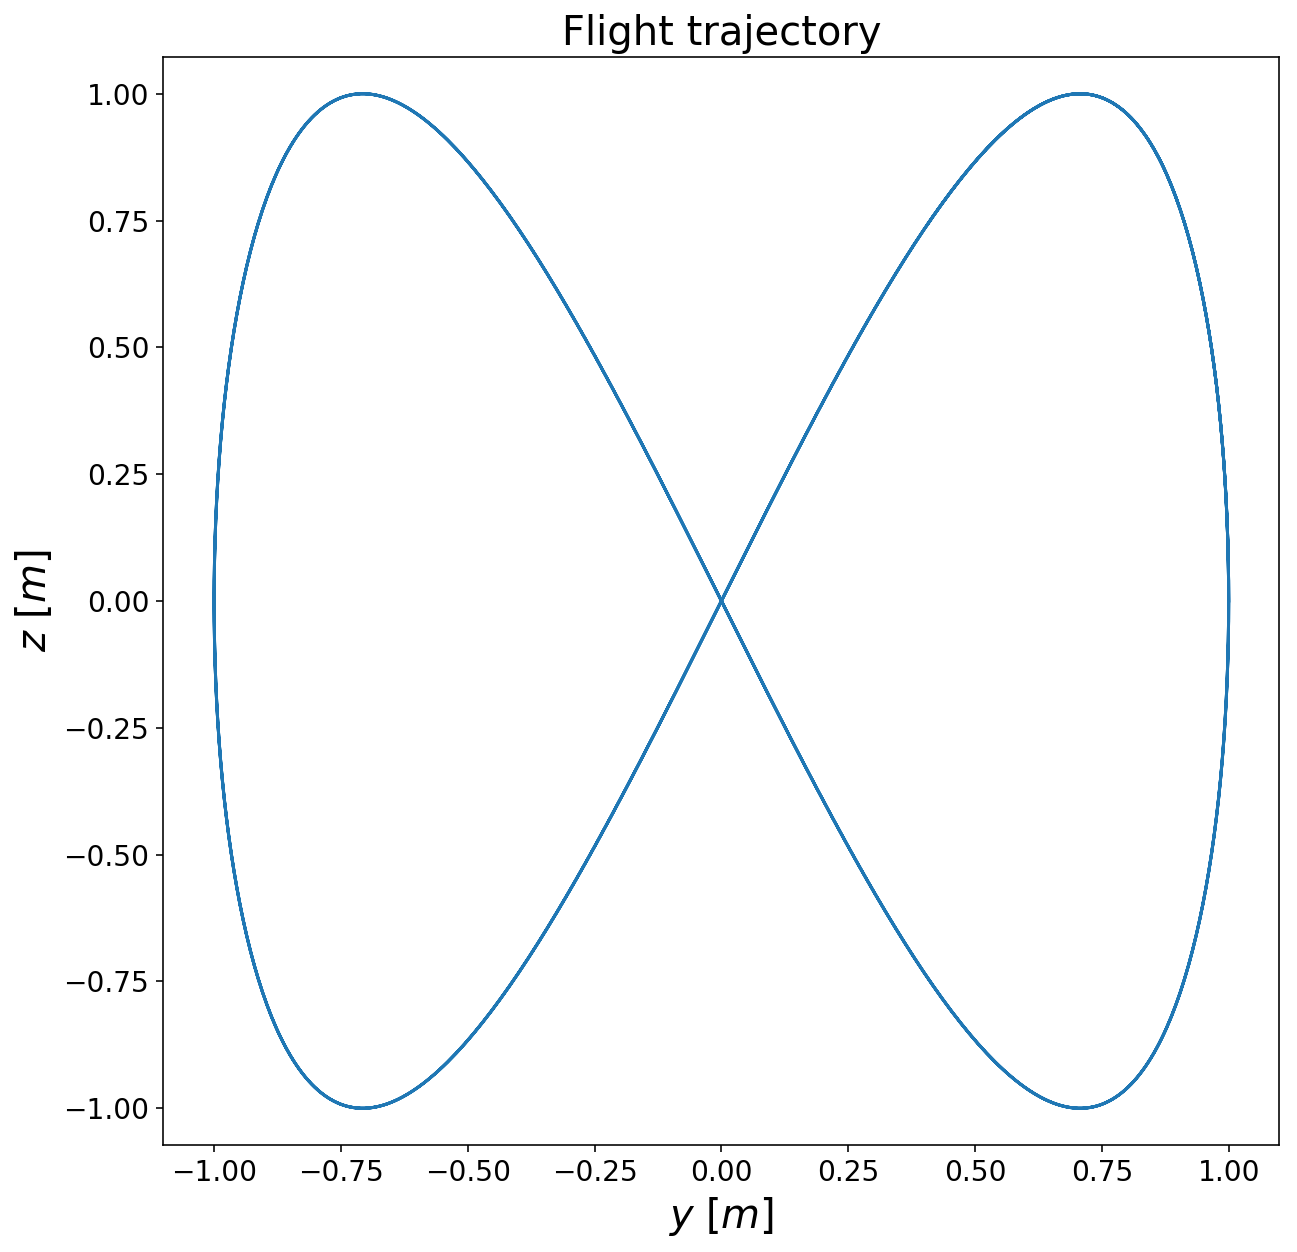

In [7]:
# Flight path is 
total_time = 200.0
dt = 0.1
omega_z = 0.2
omega_y = 0.1
a_z = 1.0
a_y = 1.0 

t=np.linspace(0.0,total_time,int(total_time/dt))

# desired path over time 
z_path = a_z * np.sin(omega_z * t)
# desired velocity over time in order to execute the given flight path
z_dot_path = a_z * omega_z * np.cos(omega_z * t)
# desired acceleration over time in order to execute the given flight path
z_dot_dot_path= -a_z * omega_z**2 * np.sin(omega_z * t)


# desired path over time 
y_path = a_y * np.cos(omega_y * t)
# desired velocity over time in order to execute the given flight path
y_dot_path = -a_y * omega_y * np.sin(omega_y * t)
# desired acceleration over time in order to execute the given flight path
y_dot_dot_path= -a_y * omega_y**2 * np.cos(omega_y * t)


plt.plot(y_path,z_path)
plt.axis('equal')
plt.title('Flight trajectory').set_fontsize(20)
plt.xlabel('$y$ [$m$]').set_fontsize(20)
plt.ylabel('$z$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

### Executing the flight

As mentioned in class the inner loop controller responsible for torque runs at the higher frequency than the ones that are responsible for the total thrust and the desired roll angle. First, we will declare how fast the inner controller runs compared to others. 

The executing flight starts with pre-flight preparation of first declaring the drone object and controller object and then provide the initial state of the drone next will initialize the array that records the drone state over time. 

Compared to the previous version the flight is executed by marching through time and transferring the desired trajectory to the drone which will generate the output of commanded thrust $u_1$ and roll angle $\phi_{commanded}$. Next, the inner controller is executed for as much as it is faster compared to the external PD controllers. During each time the proper torque value is generated $u_2$. The given parameters are transferred to the drone to update the state based on the $u_1$, $u_2$ with time advance of $dt'$. Where $dt'$ is inner controller time step. 

_Direction:_ input controller coefficients manually. As each controller is responsible for different parameters, it is possible that the coefficients might be several orders of magnitude different from each other. 

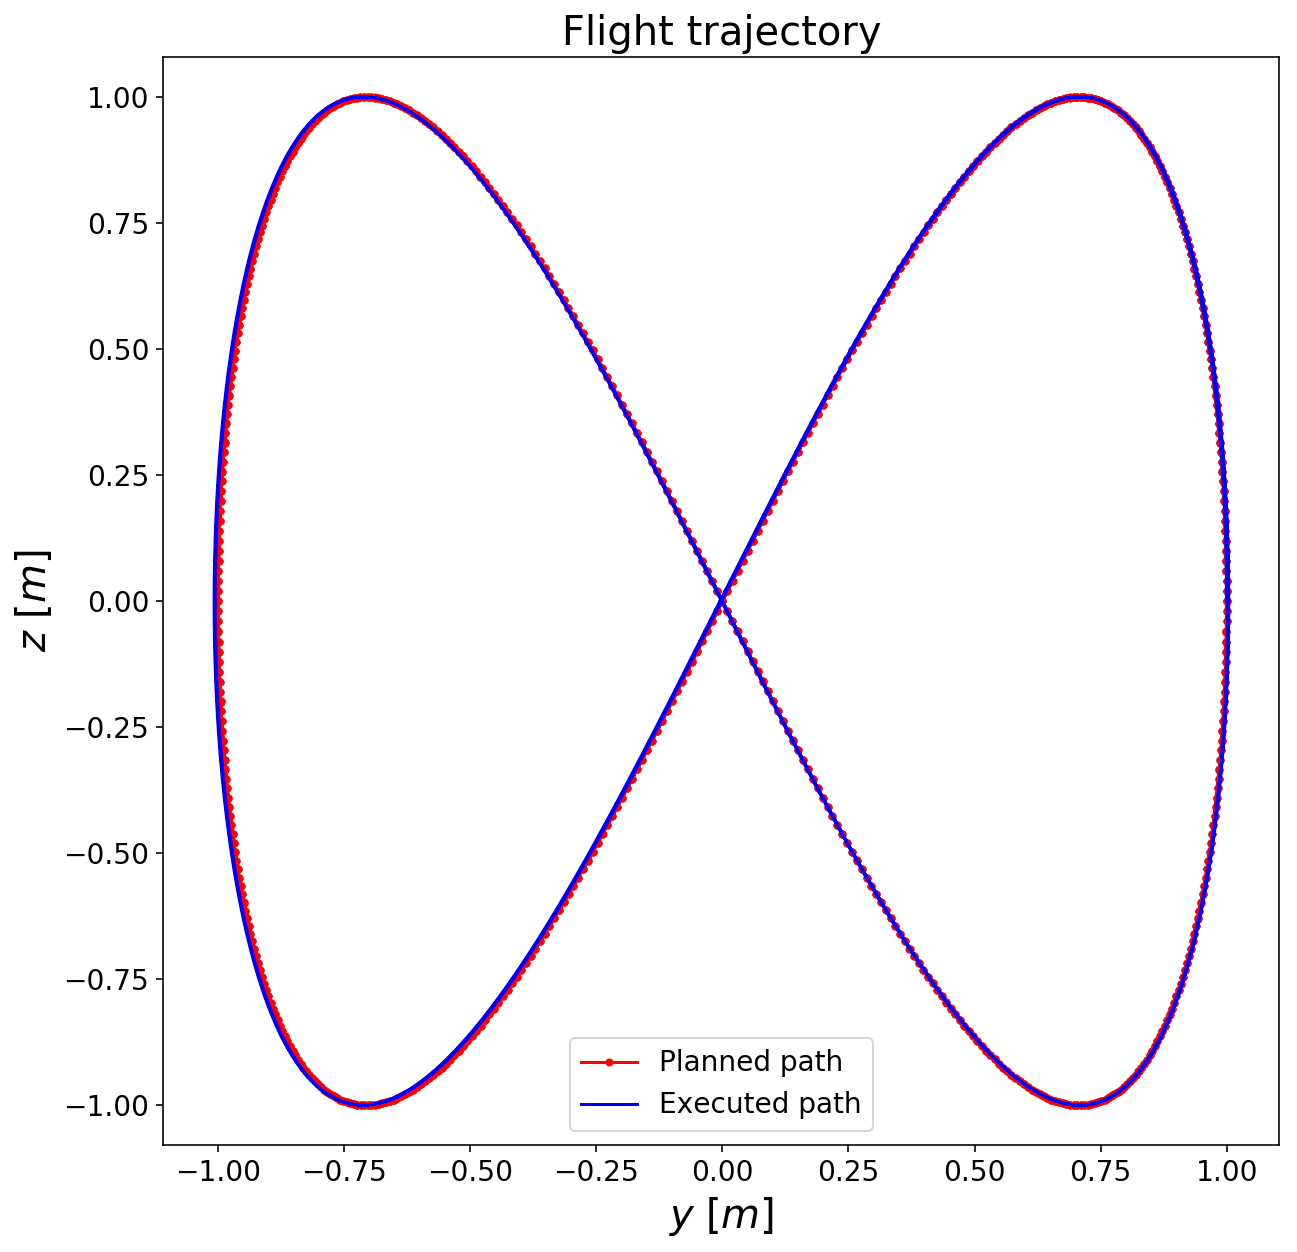

In [8]:
# how has is inner loop compared to external one 
inner_loop_acc = 10

# creating the co-axial drone object 
Controlled_Drone=LinearDroneInTwoD()

# creating the control system object 
control_system = LinearCascadingController(Controlled_Drone.m,
                                           Controlled_Drone.I_x,
                                             z_k_p=0.1,   
                                             z_k_d=10.0,   
                                             y_k_p=0.1,
                                             y_k_d=10.0,
                                             phi_k_p=10.0,
                                             phi_k_d=50.0)

# declaring the initial state of the drone with zero hight and zero velocity 
Controlled_Drone.X = np.array([z_path[0],
                               y_path[0],
                               math.atan2(y_dot_path[0],z_dot_path[0]),
                               z_dot_path[0],
                               y_dot_path[0],
    (math.atan2(y_dot_path[1],z_dot_path[1])-math.atan2(y_dot_path[0],z_dot_path[0]))/dt])

# array for recording the state history 
linear_drone_state_history = Controlled_Drone.X

# executing the flight
for i in range(0,z_path.shape[0]-1):
    
    
    u_1 = control_system.altitude_controller(z_path[i],
                                           Controlled_Drone.X[0],
                                           z_dot_path[i],
                                           Controlled_Drone.X[3],
                                           z_dot_dot_path[i])
    
    phi_commanded = control_system.lateral_controller(y_path[i], 
                                            Controlled_Drone.X[1], 
                                            y_dot_path[i], 
                                            Controlled_Drone.X[4],
                                            y_dot_dot_path[i])
    
    for _ in range(inner_loop_acc):
        
        u_2 = control_system.attitude_controller(phi_commanded, 
                                                 Controlled_Drone.X[2], 
                                                 0.0, 
                                                 Controlled_Drone.X[5])
        
        
        # calculating the new state vector   
        drone_state = Controlled_Drone.advance_state(u_1, u_2,  dt/inner_loop_acc)

    
    # generating a history of vertical positions for the drone
    linear_drone_state_history = np.vstack((linear_drone_state_history, drone_state))


plt.plot( y_path, z_path,linestyle='-',marker='.',color='red')
plt.plot(linear_drone_state_history[:,1],linear_drone_state_history[:,0],linestyle='-',color='blue')
plt.title('Flight trajectory').set_fontsize(20)
plt.xlabel('$y$ [$m$]').set_fontsize(20)
plt.ylabel('$z$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Planned path','Executed path'],fontsize = 14)
plt.axis('equal')
plt.show()

# Non-linear Drone 

The non_linear drone contrary to the linear drone will not try to expand the trigonometric functions and will not use their approximated form

$$
\begin{align}
\ddot{z} &= g - \frac{k_f}{m}(\omega_1^2+\omega_2^2) \cos(\phi) \\
\ddot{y} &= \frac{k_f}{m}(\omega_1^2+\omega_2^2) \sin(\phi)\\
\ddot{\phi} &= \frac{l k_f}{I}(\omega_1^2 - \omega_2^2) 
\end{align}
$$
Using the total thrust and the torque values obtained from the controller the nonlinear drone dynamic has the next form.
$$
\begin{align}
\ddot{z} &= (g - \frac{u_1}{m})\cos{\phi} \\
\ddot{y} &= g\sin{\phi} \\
\ddot{\phi} &= \frac{u_2}{I_{xx}}
\end{align}
$$

The nonlinear drone object is similar to the linear drone object with the addition of the nonlinear terms to calculate the drones acceleration in vertical and horizontal directions. 

In [9]:
class NonLinearDroneInTwoD:
    
    def __init__(self,
                 I_x = 0.1, # moment of inertia around the x-axis
                 m = 0.2,   # mass of the vehicle 
                ):
        
        self.I_x = I_x
        self.m = m
        
        self.u1 = 0.0
        self.u2 = 0.0
        self.g = 9.81
        
        self.X = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
    
    @property
    def y_dot_dot(self):
        phi = self.X[2]
        return self.g * math.sin(phi)
    
    @property
    def z_dot_dot(self):
        phi = self.X[2]
        return self.g - self.u1*math.cos(phi)/self.m
    
    @property
    def phi_dot_dot(self):
        return self.u2 / self.I_x
    
    def advance_state(self, u1, u2,  dt):
        self.u1 = u1
        self.u2 = u2
        
        X_dot = np.array([self.X[3], 
                        self.X[4],
                        self.X[5], 
                        self.z_dot_dot,
                        self.y_dot_dot, 
                        self.phi_dot_dot])
        
        
        # Change in state will be 
        self.X = self.X + X_dot * dt
        return self.X 

### Nonlinear Controller
In this section, we will create the controller object described in class. The schematic description of the cascading controller looks like next:
<img src="CascadingController2.png" width="800" >

The controller architecture uses three PD controllers to control the drone. One PD controller is used to generate the thrust and control the altitude while two PD controllers are used to control the lateral motion. The first one receives the desired lateral position information containing $y$ , $\dot{y}$ and $\ddot{y}$ based on which is outputs the commanded $\phi$ roll angle. The second PD controller is used to sets a torque value to achieve the desired angle. In most cases, the inner controller responsible for roll angle operates at the higher frequency than the ones that are used to control the position. 

In [10]:
class NonLinearCascadingController:
    
    def __init__(self,
                 m,
                 I_x,
                 z_k_p=1.0,   
                 z_k_d=1.0,   
                 y_k_p=1.0,
                 y_k_d=1.0,
                 phi_k_p=1.0,
                 phi_k_d=1.0):
        
        self.z_k_p = z_k_p
        self.z_k_d = z_k_d   
        self.y_k_p = y_k_p
        self.y_k_d = y_k_d
        self.phi_k_p = phi_k_p
        self.phi_k_d = phi_k_d
        
        self.g = 9.81
        self.I_x = I_x
        self.m = m

The altitude PD controller will take input parameters of $(z_{target},z_{actual},\dot{z}_{target}, \dot{z}_{actual}, \ddot{z}_{target})$ and outputs the $u_1$ instead of $\bar{u}_1$. The reason behind transfering the mass and the moment of inertia of the drone to controller is to convert the $\bar{u}_1$ into $u_1$. As a reminder for nonlinear model $\bar{u_1} = (g - \frac{u_1}{m})\cos{\phi}$.

In [11]:
%%add_to NonLinearCascadingController

def altitude_controller(self, 
                z_target, 
                z_actual, 
                z_dot_target, 
                z_dot_actual,
                z_dot_dot_target,
                phi_actual):
    
    z_err = z_target - z_actual
    z_err_dot = z_dot_target - z_dot_actual

    p_term = self.z_k_p * z_err
    d_term = self.z_k_d * z_err_dot

    u_1_bar = p_term + d_term + z_dot_dot_target
    
    u_1 = self.m* (self.g - u_1_bar)/ math.cos(phi_actual)
    
    return u_1


The lateral motion is executed by rolling the drone along the $x$ axis with a small angle which will create the force along the desired motion direction. The controller takes input parameters of $(y_{target},y_{actual},\dot{y}_{target}, \dot{y}_{actual}, \ddot{y}_{target})$ and outputs the $\phi_{commanded}$ As we are using the nonlinear model we roll angle is taken as $\sin^{-1}$. Luckily the $\sin^{-1}$ function is symmetric relative to the 0 and we do not need an additional condition to track the proper angle from rolling clockwise or counterclockwise. But keep in mind that if you are using the functions that are not one to one and onto you might need to implement an additional technique to track the true proper value.

In [12]:
%%add_to NonLinearCascadingController

def lateral_controller(self, 
                        y_target,
                        y_actual, 
                        y_dot_target, 
                        y_dot_actual,
                        y_dot_dot
                        ):
    y_err = y_target - y_actual
    y_err_dot = y_dot_target - y_dot_actual

    p_term = self.y_k_p * y_err
    d_term = self.y_k_d * y_err_dot

    phi_commanded = math.asin( (p_term + d_term + y_dot_dot) / self.g )
    
    return phi_commanded 


Attitude controller uses the same PD controller which will take input from the lateral direction controller $\phi_{commanded}$ and will output the torque value. Keep in mind that we are using PD controller and giving $\phi_{commanded}$ and $\dot{\phi}_{commanded} = 0 $.

In [13]:
%%add_to NonLinearCascadingController

def attitude_controller(self, 
                        phi_target, 
                        phi_actual, 
                        phi_dot_target, 
                        phi_dot_actual
                        ):
    phi_err = phi_target - phi_actual
    phi_err_dot = phi_dot_target - phi_dot_actual

    p_term = self.phi_k_p * phi_err
    d_term = self.phi_k_d * phi_err_dot

    u_2 = (p_term + d_term ) * self.I_x
    
    return u_2

Before using the controller developed above, we need to create the flight path. Which we have chosen to be figure 8 executed for 200 seconds with position update rate of 10 Hz $(dt=0.1)$. The executed path is described as:
$$
\begin{align}
z & = a_z \sin{\omega_z t} \\
y & = a_y \cos{\omega_y t}
\end{align}
$$

where $\omega_y = \omega_z / 2$. 

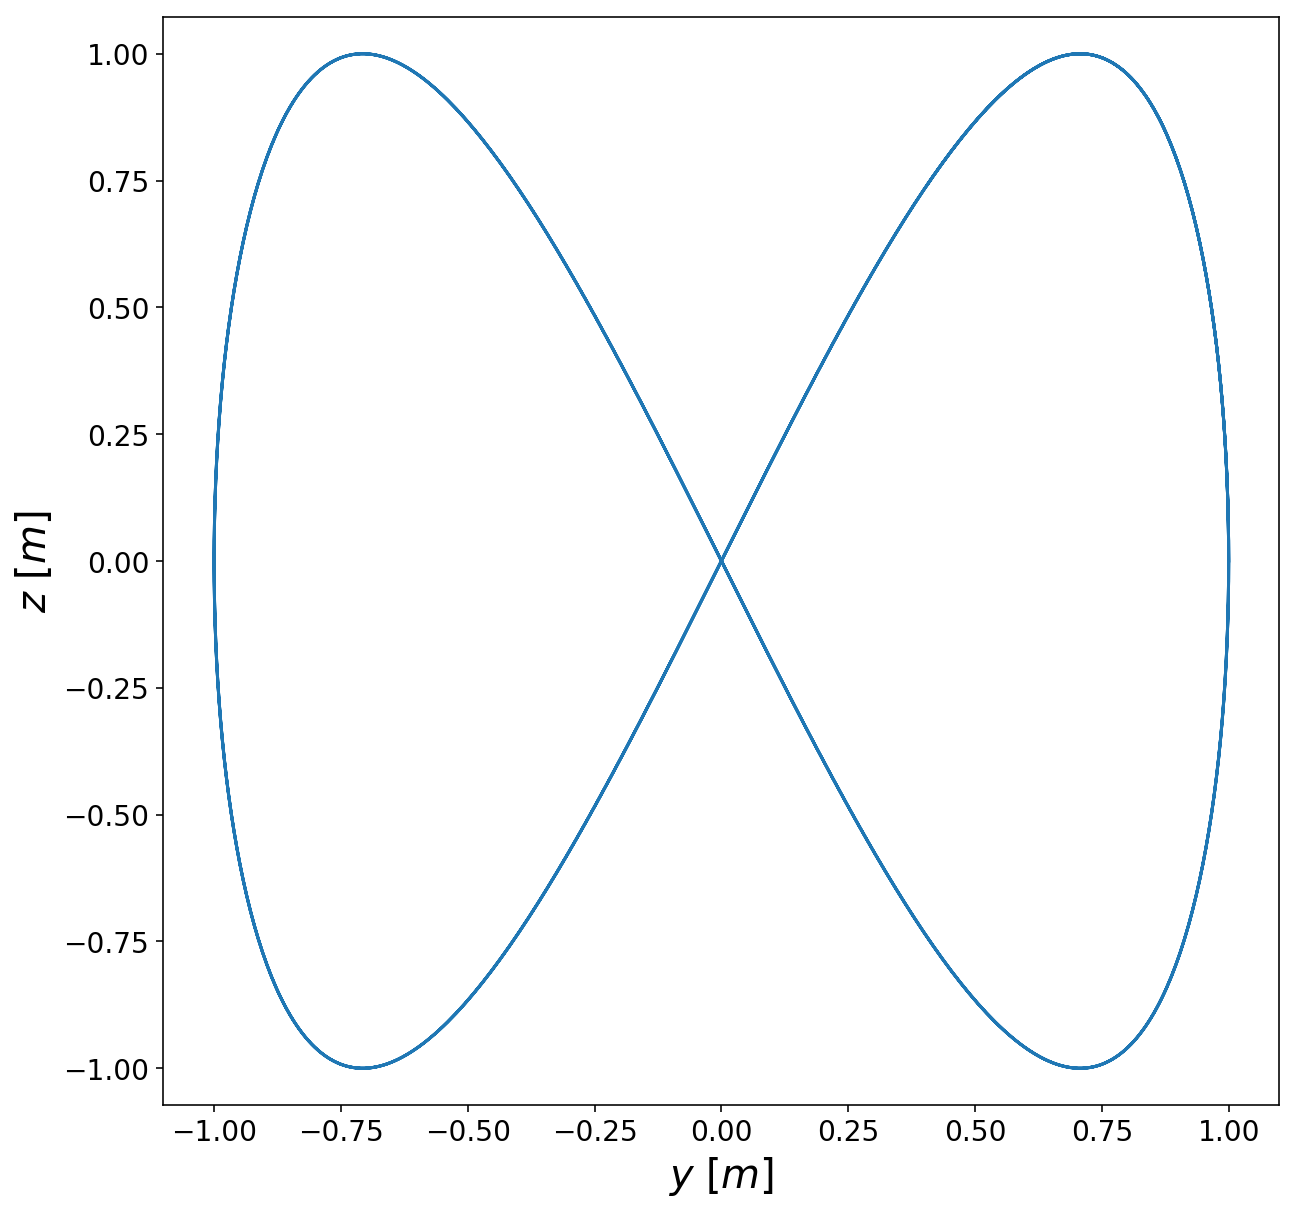

In [14]:
# Flight path is 
total_time = 200.0
dt = 0.1
omega_z = 0.2
omega_y = 0.1
a_z = 1.0#0.25
a_y = 1.0 

t=np.linspace(0.0,total_time,int(total_time/dt))

# desired path over time 
z_path = a_z * np.sin(omega_z * t)
# desired velocity over time in order to execute the given flight path
z_dot_path = a_z * omega_z * np.cos(omega_z * t)
# desired acceleration over time in order to execute the given flight path
z_dot_dot_path= -a_z * omega_z**2 * np.sin(omega_z * t)


# desired path over time 
y_path = a_y * np.cos(omega_y * t)
# desired velocity over time in order to execute the given flight path
y_dot_path = -a_y * omega_y * np.sin(omega_y * t)
# desired acceleration over time in order to execute the given flight path
y_dot_dot_path= -a_y * omega_y**2 * np.cos(omega_y * t)


plt.plot(y_path,z_path)
plt.axis('equal')
plt.xlabel('$y$ [$m$]').set_fontsize(20)
plt.ylabel('$z$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

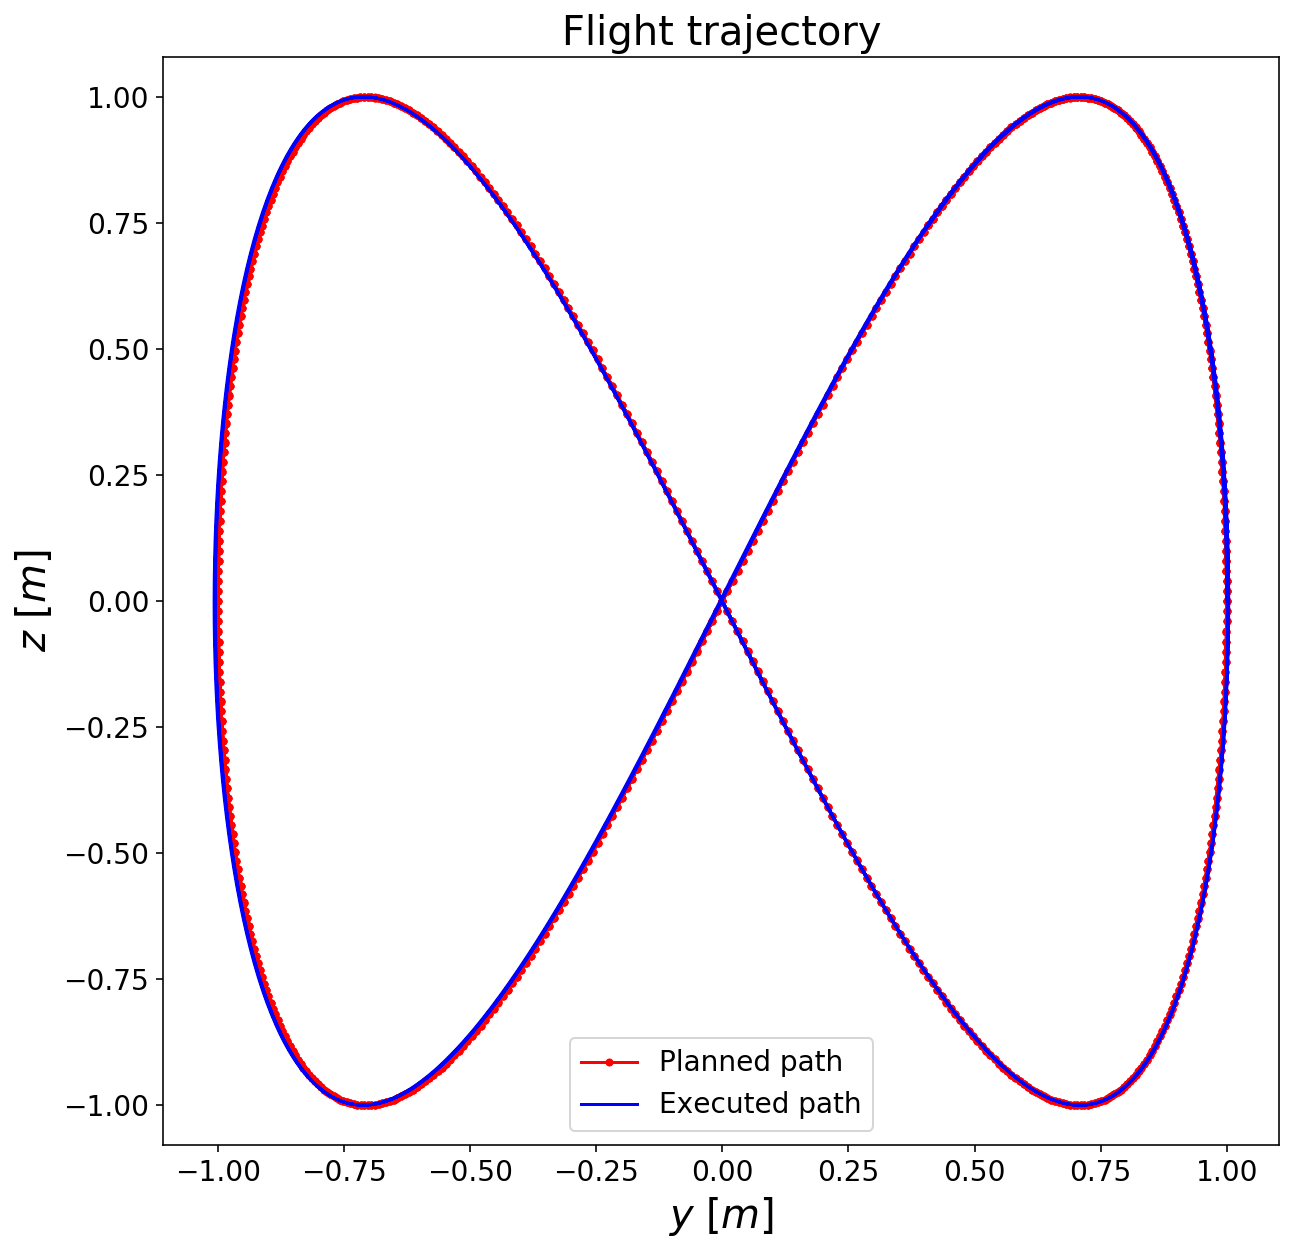

In [15]:
# how fast is inner loop compared to external one 
inner_loop_acc = 10

t1=np.linspace(0.0,total_time,int(total_time*inner_loop_acc/dt))

# creating the co-axial drone object 
Controlled_Drone=NonLinearDroneInTwoD()

# creating the control system object 
control_system = NonLinearCascadingController(Controlled_Drone.m,
                                             Controlled_Drone.I_x,
                                             z_k_p=0.1,   
                                             z_k_d=10.0,   
                                             y_k_p=0.1,
                                             y_k_d=10.0,
                                             phi_k_p=10.0,
                                             phi_k_d=50.0
                                          )

# declaring the initial state of the drone with zero hight and zero velocity 
Controlled_Drone.X = np.array([z_path[0],
                               y_path[0],
                               math.atan2(y_dot_path[0],z_dot_path[0]),
                               z_dot_path[0],
                               y_dot_path[0],
    (math.atan2(y_dot_path[1],z_dot_path[1])-math.atan2(y_dot_path[0],z_dot_path[0]))/dt])

# array for recording the state history 
non_linear_drone_state_history = Controlled_Drone.X


# executing the flight
for i in range(0,z_path.shape[0]-1):
    
    
    u_1 = control_system.altitude_controller(z_path[i],
                                           Controlled_Drone.X[0],
                                           z_dot_path[i],
                                           Controlled_Drone.X[3],
                                           z_dot_dot_path[i],
                                           Controlled_Drone.X[2])
    
    phi_commanded = control_system.lateral_controller(y_path[i], 
                                            Controlled_Drone.X[1], 
                                            y_dot_path[i], 
                                            Controlled_Drone.X[4],
                                            y_dot_dot_path[i])
    
    for _ in range(inner_loop_acc):
        
        u_2 = control_system.attitude_controller(phi_commanded, 
                                                 Controlled_Drone.X[2], 
                                                 0.0, 
                                                 Controlled_Drone.X[5])
        
        
        # calculating the new state vector   
        drone_state = Controlled_Drone.advance_state(u_1, u_2,  dt/inner_loop_acc)

    # generating a history of vertical positions for the drone
    non_linear_drone_state_history = np.vstack((non_linear_drone_state_history, drone_state))


plt.plot( y_path, z_path,linestyle='-',marker='.',color='red')
plt.plot(non_linear_drone_state_history[:,1],non_linear_drone_state_history[:,0],linestyle='-',color='blue')
plt.title('Flight trajectory').set_fontsize(20)
plt.xlabel('$y$ [$m$]').set_fontsize(20)
plt.ylabel('$z$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Planned path','Executed path'],fontsize = 14)
plt.axis('equal')
plt.show()


# Comparison of linear and non-linear controllers 

In this section, we will compare the linear and nonlinear controllers by analyzing the path that drones took relative to the desired path.

For comparizon use the next set of controller inputs `z_k_p=0.1, z_k_d=10.0, y_k_p=0.1, y_k_d=10.0, phi_k_p=10.0, phi_k_d=50.0`. 
Execute flight using both linear and nonlinear controllers. The vehicle state over time will be recorded in `non_linear_drone_state_history` for flight executed by the nonlinear controller and in `linear_drone_state_history` for flight executed by the linear controller. 


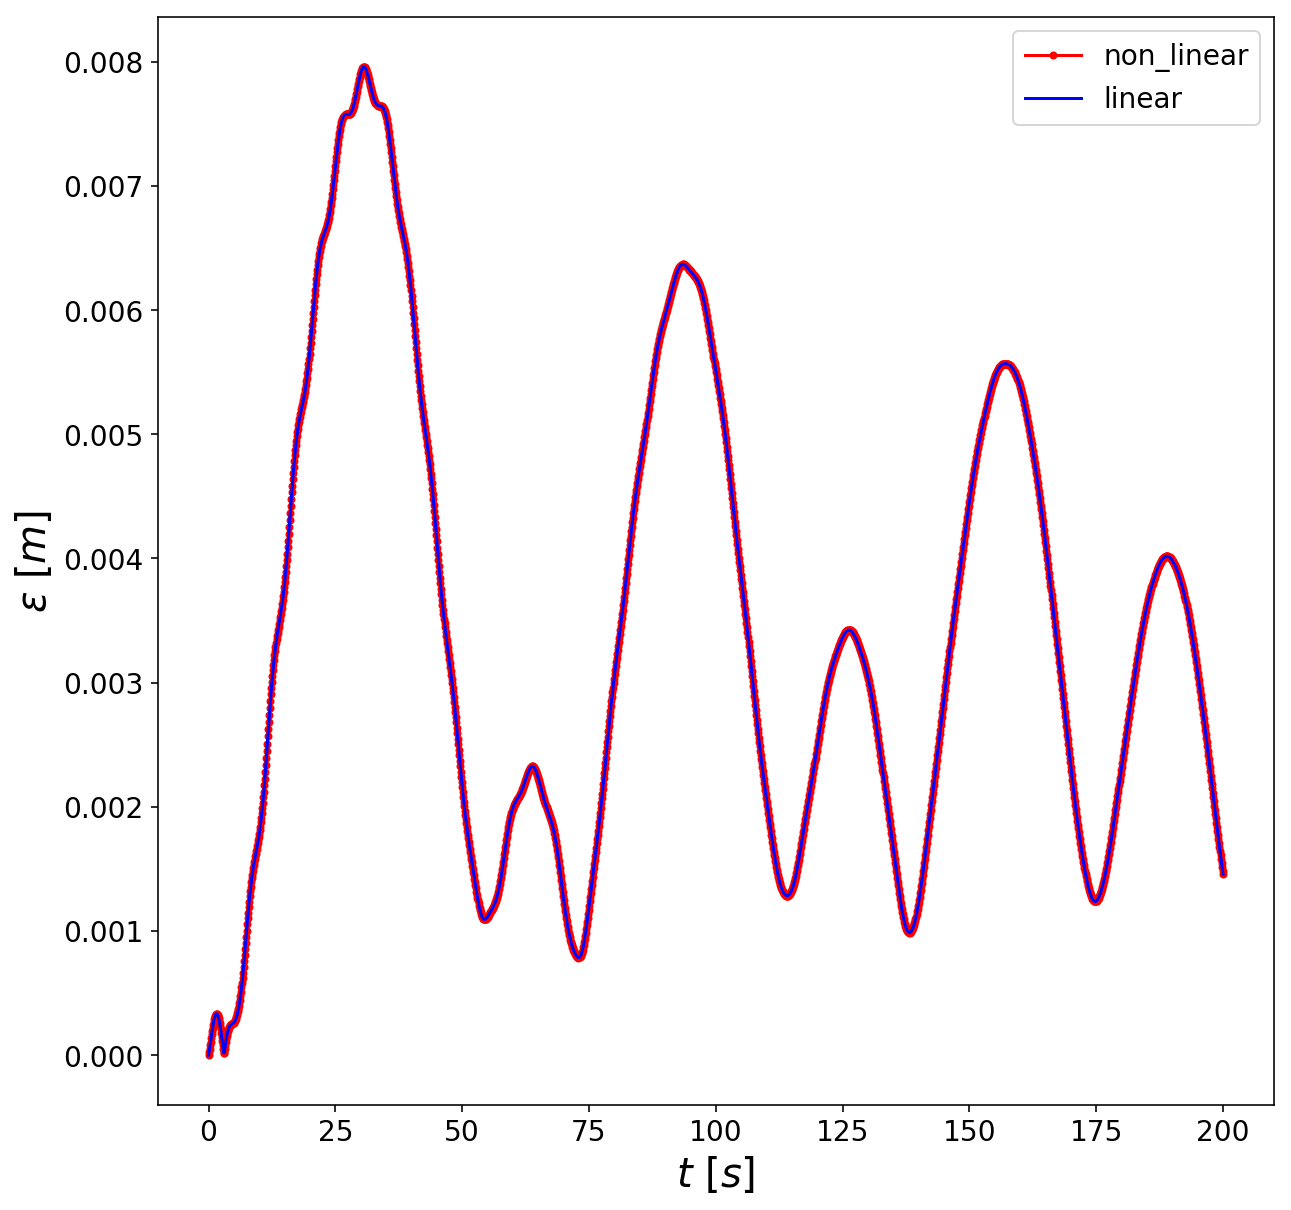

In [16]:
# Error calculation 

non_linear_Err= np.sqrt((non_linear_drone_state_history[:,1] - y_path[:])**2 \
                        +(non_linear_drone_state_history[:,0] - z_path[:])**2)
linear_Err= np.sqrt((linear_drone_state_history[:,1] - y_path[:])**2 \
                    + (linear_drone_state_history[:,0] - z_path[:])**2)
    
t1=np.linspace(0.0,total_time,int(total_time*inner_loop_acc/dt))

plt.plot(t,non_linear_Err,color='red',marker='.')
plt.plot(t,linear_Err,color='blue')
plt.xlabel('$t$ [$s$]').set_fontsize(20)
plt.ylabel('$\epsilon$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['non_linear','linear'],fontsize = 14)
plt.show()

If you were able to obtain the flight paths which are virtually similar for the linear and nonlinear controllers it is because the angle of roll is changing little from the 0. Next plot will show the roll angle over time. As mentioned above for the small roll angle $\sin{\phi} = \phi$ and $\cos{\phi} = 1$. Unfortunately, this assumption is not true for the large angles what is why for the second set of parameters the flight path executed by non-linear controller looks different from the flight path executed linear controller. 

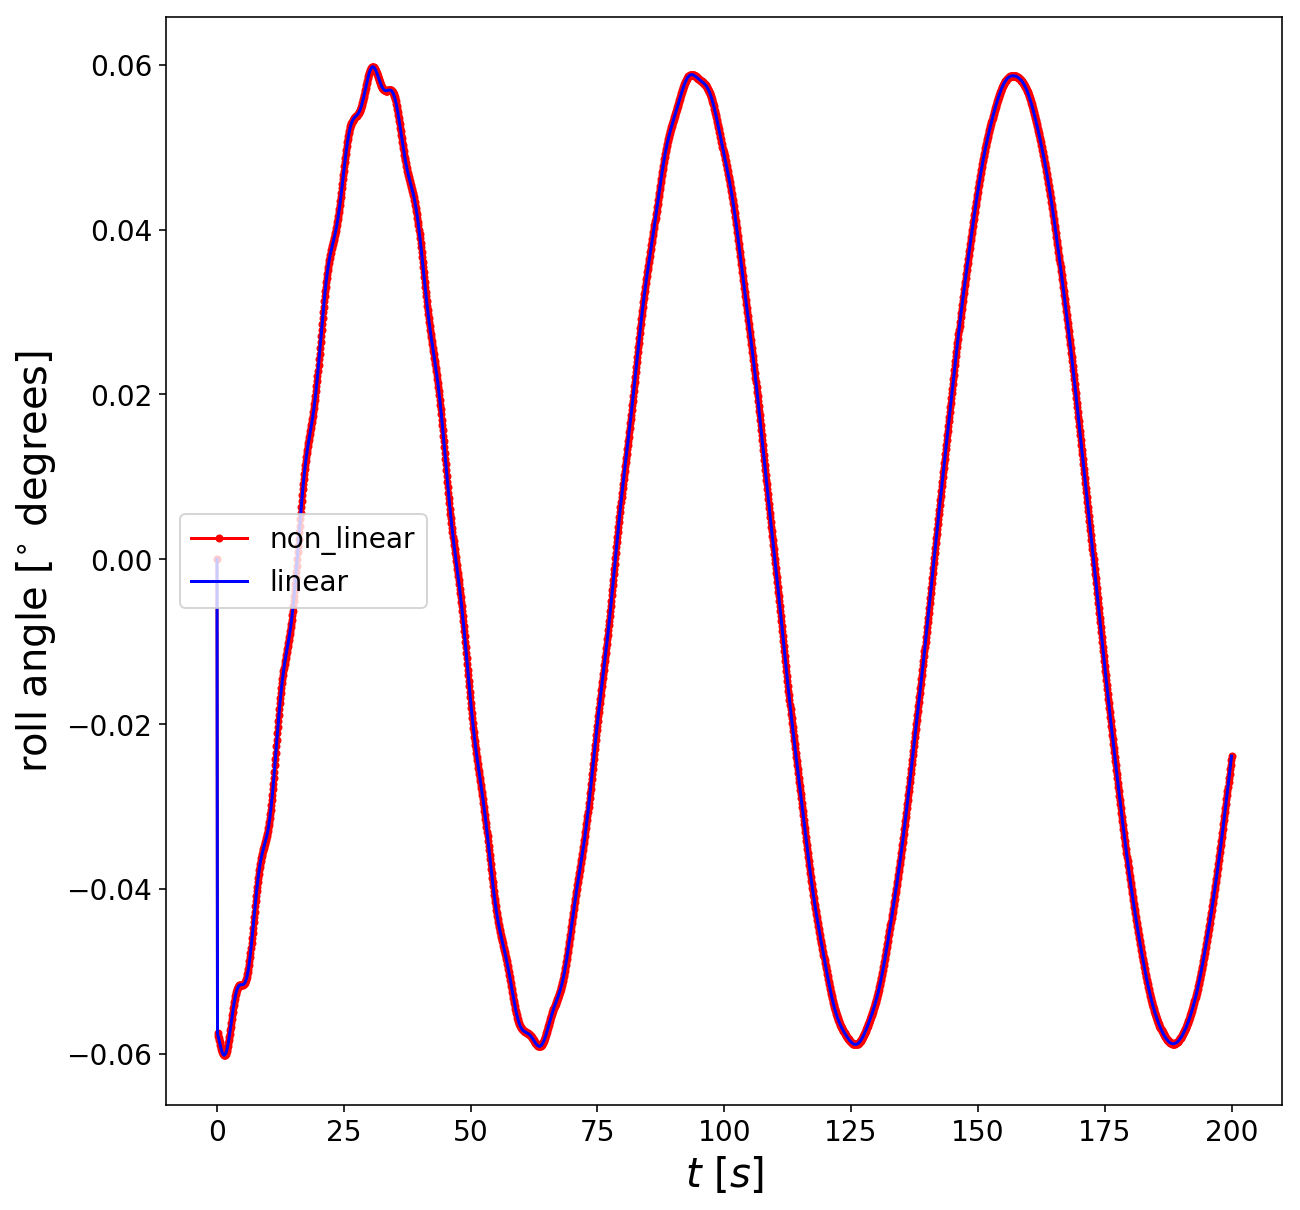

In [17]:
plt.plot(t,non_linear_drone_state_history[:,2]*180/math.pi,color='red', marker= '.')
plt.plot(t,linear_drone_state_history[:,2]*180/math.pi,color='blue')
plt.xlabel('$t$ [$s$]').set_fontsize(20)
plt.ylabel('roll angle [$^{\circ}$ degrees]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['non_linear','linear'],fontsize = 14)
plt.show()